In [476]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import *

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline

from rfpimp import *

import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("./wine-reviews/winemag-data-130k-v2.csv", index_col=0)
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


In [10]:
# counts of missing values
df.isnull().sum().sort_values(ascending=False)

region_2                 79460
designation              37465
taster_twitter_handle    31213
taster_name              26244
region_1                 21247
price                     8996
province                    63
country                     63
variety                      1
winery                       0
title                        0
points                       0
description                  0
dtype: int64

In [11]:
# percentages of missing values
df.isnull().sum().sort_values(ascending=False)/len(df)

region_2                 0.611367
designation              0.288257
taster_twitter_handle    0.240154
taster_name              0.201922
region_1                 0.163475
price                    0.069215
province                 0.000485
country                  0.000485
variety                  0.000008
winery                   0.000000
title                    0.000000
points                   0.000000
description              0.000000
dtype: float64

In [12]:
df.nunique()

country                      43
description              119955
designation               37979
points                       21
price                       390
province                    425
region_1                   1229
region_2                     17
taster_name                  19
taster_twitter_handle        15
title                    118840
variety                     707
winery                    16757
dtype: int64

In [17]:
# correlation between the two numeric columns, points (score) and price
df.corr()

,points,price
points,1.000000,0.416167
price,0.416167,1.000000


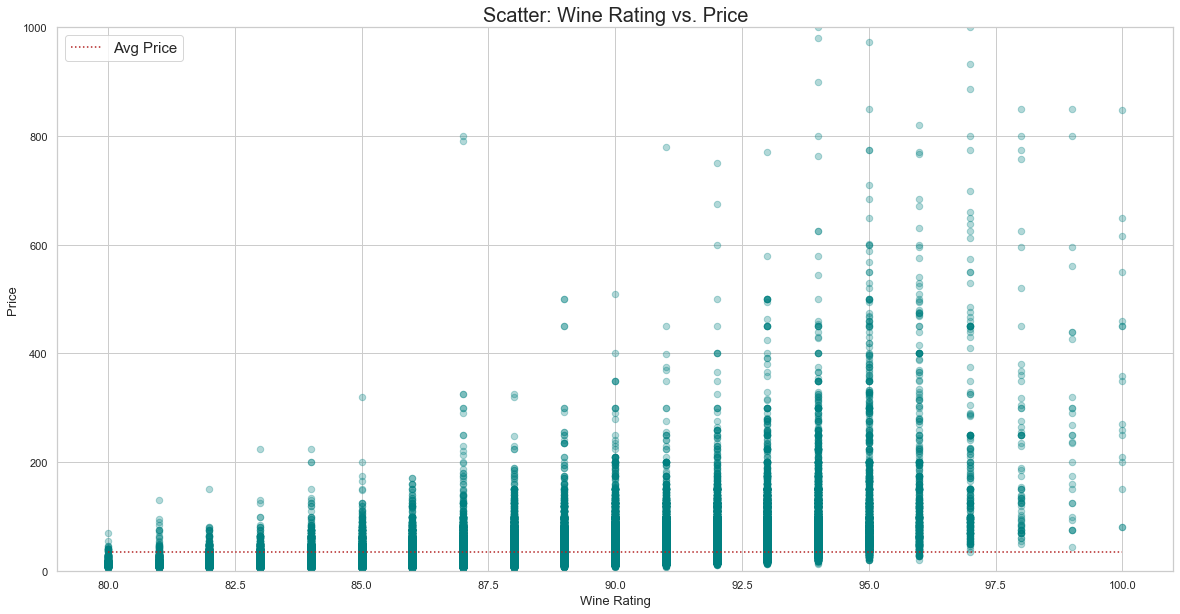

In [181]:
# scatterplot
fig = plt.figure(figsize=(20,10))
plt.scatter(df.points, df.price, alpha=.3, s=42, c='teal',)
plt.ylim((0, 1000))
plt.hlines(35.3, xmin=80, xmax=100, linestyles='dotted', colors='firebrick', label='Avg Price')
plt.title('Scatter: Wine Rating vs. Price', size=20)
plt.xlabel('Wine Rating', size=13)
plt.ylabel('Price', size=13)
plt.legend(loc = 2, fontsize=15)
plt.show()

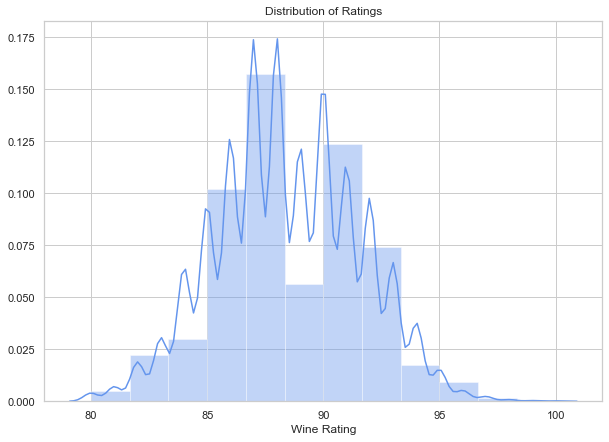

In [359]:
fig = plt.figure(figsize=(10,7))
sns.distplot(df.points, bins=12, color='cornflowerblue')
plt.title('Distribution of Ratings')
plt.xlabel('Wine Rating')
plt.show()

In [180]:
# countries with more than 100 wine ratings 
country_cts = df.groupby('country')['description'].count()
country_many_reviews = country_cts[country_cts > 100].index
country_many_reviews

Index(['Argentina', 'Australia', 'Austria', 'Bulgaria', 'Canada', 'Chile',
       'France', 'Germany', 'Greece', 'Hungary', 'Israel', 'Italy',
       'New Zealand', 'Portugal', 'Romania', 'South Africa', 'Spain', 'US',
       'Uruguay'],
      dtype='object', name='country')

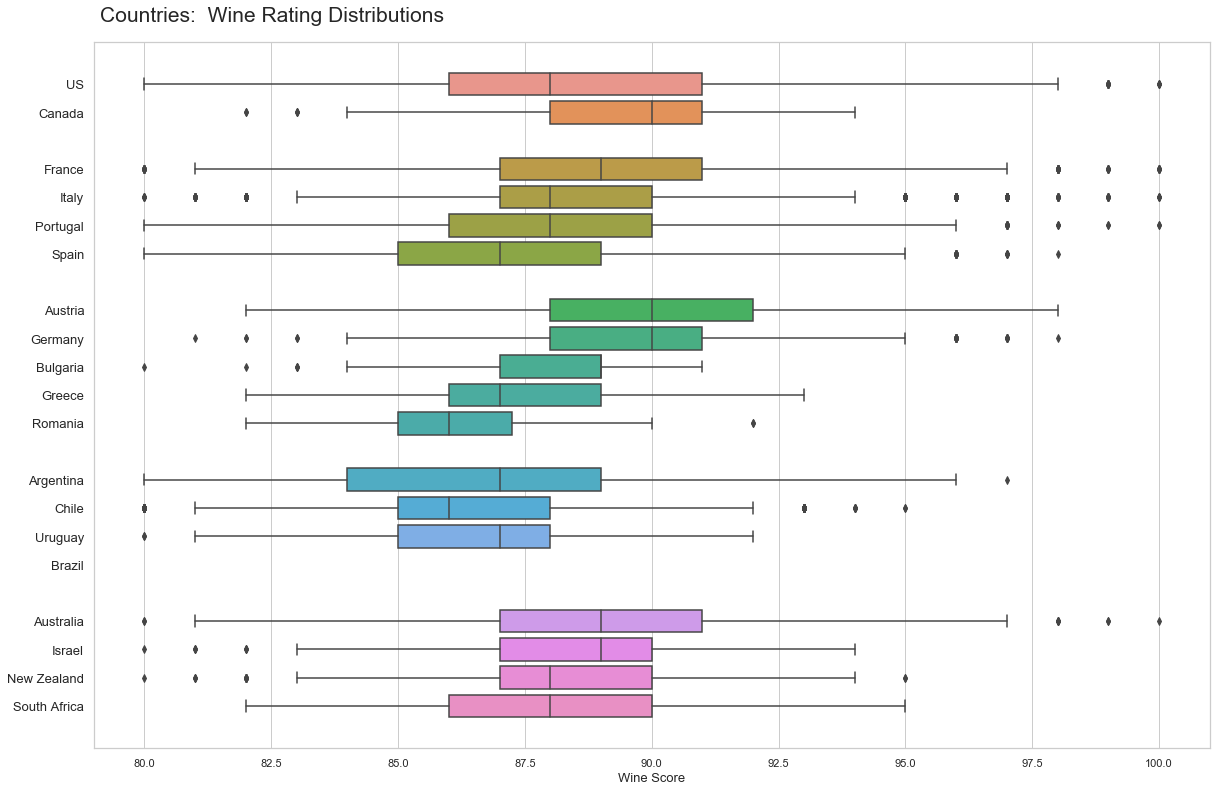

In [260]:
plt.figure(figsize=(20,13))

# data=df[df.country.isin(country_many_reviews)

sns.boxplot(x="points", y="country", data=df[df.country.isin(country_many_reviews)],
           order=['','US','Canada',
                  '','France','Italy','Portugal','Spain',
                  '','Austria','Germany','Bulgaria','Greece','Romania',
                  '','Argentina','Chile','Uruguay','Brazil',
                  '','Australia','Israel','New Zealand','South Africa',''])
                  

plt.title('Countries:  Wine Rating Distributions', x=.16, y=1.02, fontsize=21)

plt.xlabel('Wine Score', size=13)
plt.ylabel('', size=13)
plt.yticks(fontsize=13)
plt.show()

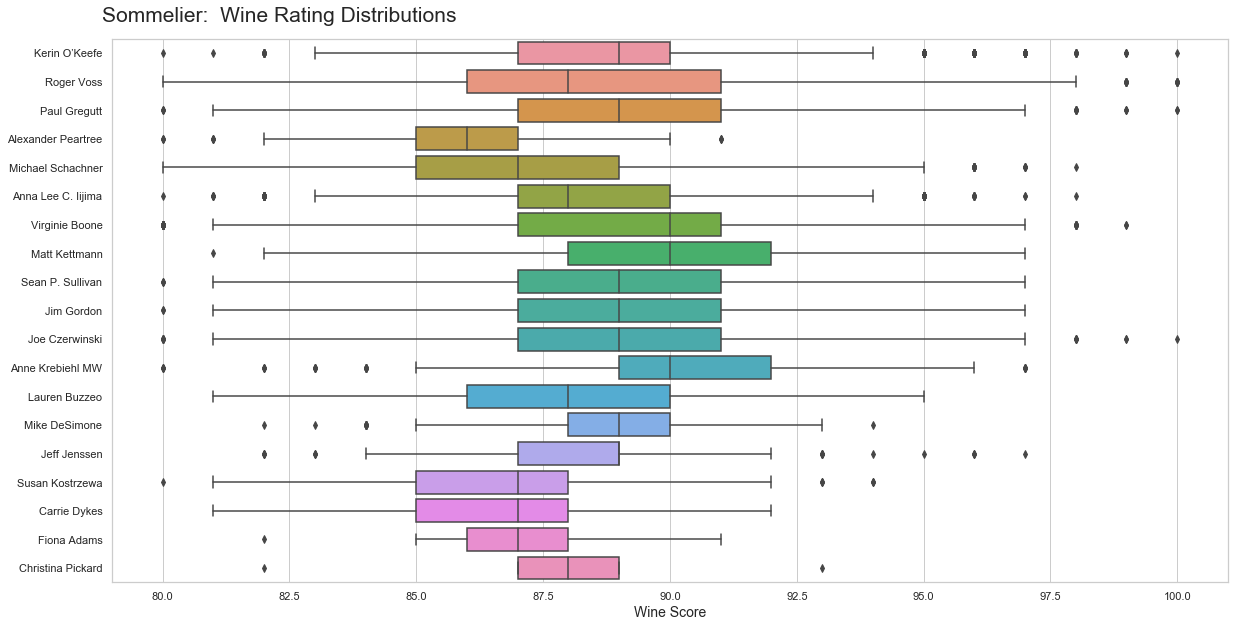

In [337]:
plt.figure(figsize=(20,10))
sns.boxplot(x="points", y="taster_name", data=df)

plt.title('Sommelier:  Wine Rating Distributions', x=.15, y=1.02, fontsize=21)

plt.xlabel('Wine Score', size=14)
plt.ylabel('', size=13)
plt.show()

In [264]:
df.columns

Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title',
       'variety', 'winery'],
      dtype='object')

In [385]:
province_gb = df.groupby('province')['points'].aggregate({"points": ["mean", "median", "count"]})
province_gb.columns = ['_'.join(col).strip() for col in province_gb.columns]
province_many_reviews = province_gb[province_gb.points_count > 65].reset_index()
province_many_reviews

,province,points_mean,points_median,points_count
0,Aconcagua Valley,88.163793,88.0,116
1,Alentejano,87.905016,88.0,937
2,Alentejo,88.653846,88.0,182
3,Alsace,89.372131,89.0,2440
4,America,86.505263,86.0,95
...,...,...,...,...
95,Washington,88.947216,89.0,8639
96,Weinviertel,89.560000,90.0,100
97,Western Australia,88.912587,89.0,286
98,Western Cape,86.733096,87.0,281


In [397]:
co_province_gb = df.groupby(['country','province'])['points'].aggregate({"points": ["mean", "median", "count"]})
co_province_gb.columns = ['_'.join(col).strip() for col in co_province_gb.columns]
co_province_many_reviews = co_province_gb[co_province_gb.points_count > 500].reset_index()
co_province_many_reviews

,country,province,points_mean,points_median,points_count
0,Argentina,Mendoza Province,86.826593,87.0,3264
1,Argentina,Other,86.001866,86.0,536
2,Australia,South Australia,89.037806,89.0,1349
3,Austria,Burgenland,89.619048,90.0,672
4,Austria,Niederösterreich,88.936667,89.0,600
5,Chile,Casablanca Valley,86.237937,86.0,601
6,Chile,Colchagua Valley,87.098795,87.0,830
7,Chile,Maipo Valley,86.825493,87.0,659
8,France,Alsace,89.372131,89.0,2440
9,France,Beaujolais,87.954981,88.0,1044


In [ ]:
# To Implement:
# First Linear Base Models
# Regularization variations
# See what features are dropped
# Examine B's

# Metrics > Switch to Median Absolute Error

# Run Basic Version Before Heavy Feature Engineering

In [415]:
# price is the only numeric column
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 18.9+ MB


In [632]:
price = df['price']
price = price.fillna(price.median()).to_numpy().reshape(-1,1)

X_baseline = price
y = df['points'].to_numpy().reshape(-1,1)

In [454]:
X_train_b, X_test_b, y_train, y_test = train_test_split(X_baseline, y, test_size=0.20, random_state=42)

In [572]:
%time
lr = LinearRegression(n_jobs=-1)
lr.fit(X_train_b, y_train)
y_pred_b = lr.predict(X_test_b)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [573]:
def evaluate(y_test, y_pred):

    results = {'R-Sq' : r2_score(y_test, y_pred),
               'MeanAE' : mean_absolute_error(y_test, y_pred),
               'Median AE' : median_absolute_error(y_test, y_pred),
               'Explained Variance': explained_variance_score(y_test, y_pred),
               'Max Error': max_error(y_test, y_pred)}
                             
    return results

In [574]:
evaluate(y_test, y_pred_b)

{'R-Sq': 0.15264012961878493,
 'MeanAE': 2.229093927332663,
 'Median AE': 1.8996616638861354,
 'Explained Variance': 0.15264854477796364,
 'Max Error': 58.62538750842032}

In [576]:
%time
lasso = Lasso()
lasso.fit(X_train_b, y_train)
y_pred_lasso = lasso.predict(X_test_b)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs


In [577]:
evaluate(y_test, y_pred_lasso)

{'R-Sq': 0.15292250294470733,
 'MeanAE': 2.232062187832121,
 'Median AE': 1.910268896111731,
 'Explained Variance': 0.15293097697343383,
 'Max Error': 57.349498244316834}

In [578]:
%time
ridge = Ridge()
ridge.fit(X_train_b, y_train)
y_pred_ridge = ridge.predict(X_test_b)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.96 µs


In [579]:
evaluate(y_test, y_pred_ridge)

{'R-Sq': 0.15264012972472385,
 'MeanAE': 2.2290939281845374,
 'Median AE': 1.8996616672690578,
 'Explained Variance': 0.1526485448839201,
 'Max Error': 58.62538712894295}

# One Hot Encoding

In [594]:
hot_tasters = pd.get_dummies(df['taster_name'], prefix='T')
hot_countries = pd.get_dummies(df['country'], prefix='C') 
hot_regions = pd.get_dummies(df['region_2'], prefix='R')

In [591]:
hot_tasters

,T_Alexander Peartree,T_Anna Lee C. Iijima,T_Anne Krebiehl MW,T_Carrie Dykes,T_Christina Pickard,T_Fiona Adams,T_Jeff Jenssen,T_Jim Gordon,T_Joe Czerwinski,T_Kerin O’Keefe,T_Lauren Buzzeo,T_Matt Kettmann,T_Michael Schachner,T_Mike DeSimone,T_Paul Gregutt,T_Roger Voss,T_Sean P. Sullivan,T_Susan Kostrzewa,T_Virginie Boone
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
129967,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
129968,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
129969,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [617]:
hot_tasters.corrwith(df['price']).abs().sort_values(ascending=False)

T_Michael Schachner     0.092751
T_Virginie Boone        0.080152
T_Kerin O’Keefe         0.047891
T_Jim Gordon            0.038823
T_Roger Voss            0.035840
T_Lauren Buzzeo         0.031759
T_Susan Kostrzewa       0.028721
T_Anna Lee C. Iijima    0.026298
T_Jeff Jenssen          0.020431
T_Matt Kettmann         0.018635
T_Anne Krebiehl MW      0.017129
T_Paul Gregutt          0.012228
T_Mike DeSimone         0.011350
T_Alexander Peartree    0.009003
T_Sean P. Sullivan      0.006415
T_Carrie Dykes          0.003798
T_Fiona Adams           0.001535
T_Christina Pickard     0.001035
T_Joe Czerwinski        0.000952
dtype: float64

In [592]:
hot_countries

,C_Argentina,C_Armenia,C_Australia,C_Austria,C_Bosnia and Herzegovina,C_Brazil,C_Bulgaria,C_Canada,C_Chile,C_China,...,C_Serbia,C_Slovakia,C_Slovenia,C_South Africa,C_Spain,C_Switzerland,C_Turkey,C_US,C_Ukraine,C_Uruguay
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129967,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
129968,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129969,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [613]:
hot_countries.corrwith(df['price']).abs().sort_values(ascending=False)

C_Chile                     0.069166
C_France                    0.058434
C_Argentina                 0.047360
C_Portugal                  0.045682
C_Italy                     0.042264
C_Spain                     0.041768
C_South Africa              0.027097
C_US                        0.026605
C_Germany                   0.022445
C_New Zealand               0.022063
C_Greece                    0.019599
C_Austria                   0.017260
C_Bulgaria                  0.017252
C_Romania                   0.015456
C_Georgia                   0.010308
C_Moldova                   0.010025
C_England                   0.009503
C_Switzerland               0.009257
C_Turkey                    0.007137
C_Ukraine                   0.006858
C_Slovenia                  0.006616
C_Uruguay                   0.006559
C_Morocco                   0.005884
C_Croatia                   0.005856
C_Israel                    0.005582
C_Brazil                    0.005574
C_Mexico                    0.005031
C

In [595]:
hot_regions

,R_California Other,R_Central Coast,R_Central Valley,R_Columbia Valley,R_Finger Lakes,R_Long Island,R_Napa,R_Napa-Sonoma,R_New York Other,R_North Coast,R_Oregon Other,R_Sierra Foothills,R_Sonoma,R_South Coast,R_Southern Oregon,R_Washington Other,R_Willamette Valley
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
129967,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
129968,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
129969,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [612]:
hot_regions.corrwith(df['price']).abs().sort_values(ascending=False)

R_Napa                 0.150534
R_California Other     0.070171
R_Finger Lakes         0.044109
R_Central Valley       0.036604
R_Sonoma               0.031083
R_Sierra Foothills     0.022525
R_Southern Oregon      0.018393
R_Willamette Valley    0.017115
R_Columbia Valley      0.016611
R_New York Other       0.015135
R_Washington Other     0.014156
R_Napa-Sonoma          0.011461
R_Long Island          0.010810
R_Oregon Other         0.008865
R_South Coast          0.008478
R_North Coast          0.008461
R_Central Coast        0.002925
dtype: float64

In [631]:
price.shape

(129971,)

In [646]:
z_price = StandardScaler().fit_transform(price)
z_price = pd.DataFrame({'Z Price' : z_price.flatten()})
z_price

,Z Price
0,-0.243193
1,-0.495310
2,-0.520521
3,-0.545733
4,0.765272
...,...
129966,-0.167559
129967,1.017388
129968,-0.117135
129969,-0.066712


In [647]:
X_encoded = pd.concat([z_price, hot_regions, hot_countries, hot_tasters], axis=1)
y = df["points"]

In [648]:
X_encoded

,Z Price,R_California Other,R_Central Coast,R_Central Valley,R_Columbia Valley,R_Finger Lakes,R_Long Island,R_Napa,R_Napa-Sonoma,R_New York Other,...,T_Kerin O’Keefe,T_Lauren Buzzeo,T_Matt Kettmann,T_Michael Schachner,T_Mike DeSimone,T_Paul Gregutt,T_Roger Voss,T_Sean P. Sullivan,T_Susan Kostrzewa,T_Virginie Boone
0,-0.243193,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,-0.495310,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,-0.520521,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,-0.545733,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.765272,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,-0.167559,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129967,1.017388,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
129968,-0.117135,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
129969,-0.066712,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [649]:
X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(X_encoded, y, test_size=0.20, random_state=42)

In [650]:
lr.fit(X_train_encoded, y_train)
y_pred_encoded = lr.predict(X_test_encoded)

In [651]:
evaluate(y_test, y_pred_encoded)

{'R-Sq': 0.2543881584431049,
 'MeanAE': 2.0872938757039865,
 'Median AE': 1.7909525063213039,
 'Explained Variance': 0.25438858517606844,
 'Max Error': 54.72187890819657}

In [652]:
lasso.fit(X_train_encoded, y_train)
y_pred_encoded_lasso = lasso.predict(X_test_encoded)

In [653]:
evaluate(y_test, y_pred_encoded_lasso)

{'R-Sq': 0.05063331310096841,
 'MeanAE': 2.440277687112818,
 'Median AE': 2.329430442860172,
 'Explained Variance': 0.05064422062034224,
 'Max Error': 11.312495117742458}

In [654]:
ridge.fit(X_train_encoded, y_train)
y_pred_encoded_ridge = ridge.predict(X_test_encoded)

In [655]:
evaluate(y_test, y_pred_encoded_ridge)

{'R-Sq': 0.2543798892318633,
 'MeanAE': 2.0872746710686365,
 'Median AE': 1.7908478180578413,
 'Explained Variance': 0.2543803367476668,
 'Max Error': 54.72334581724175}

# Advanced Feature Engineering

In [598]:
len(df.variety.value_counts())

707

In [413]:
df.variety.value_counts().head(50)

Pinot Noir                       13272
Chardonnay                       11753
Cabernet Sauvignon                9472
Red Blend                         8946
Bordeaux-style Red Blend          6915
Riesling                          5189
Sauvignon Blanc                   4967
Syrah                             4142
Rosé                              3564
Merlot                            3102
Nebbiolo                          2804
Zinfandel                         2714
Sangiovese                        2707
Malbec                            2652
Portuguese Red                    2466
White Blend                       2360
Sparkling Blend                   2153
Tempranillo                       1810
Rhône-style Red Blend             1471
Pinot Gris                        1455
Champagne Blend                   1396
Cabernet Franc                    1353
Grüner Veltliner                  1345
Portuguese White                  1159
Bordeaux-style White Blend        1066
Pinot Grigio             